# Preliminares - Cargando los archivos y librerías

In [ ]:
!pip install --quiet openpyxl xgboost optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix, make_scorer, f1_score
!pip install graphviz python-graphviz
import graphviz
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler

In [ ]:
# CORRER ESTA CELDA SOLO SI SE USA DESDE COLAB, SINO IGNORARLA Y PASAR A LA SIGUIENTE

from google.colab import drive

drive.mount("/content/drive")

# Para el modelo de regresión

df_reg_red = pd.read_excel(
    "/content/drive/MyDrive/Colab Notebooks/TP-DIA/DATOS_V2_OK-SIN_AUX.xlsx",
    index_col=0,
)

df_reg_ext = pd.read_excel(
    "/content/drive/MyDrive/Colab Notebooks/TP-DIA/DATOS-OK-V3.xlsx", index_col=0
)


# Para el modelo de clasificación

df_cat_multiclass = pd.read_excel(
    "/content/drive/MyDrive/Colab Notebooks/TP-DIA/DATOS-OK-CLASES PTH_F.xlsx",
    index_col=0,
)

df_cat_binary = pd.read_excel(
    "/content/drive/MyDrive/Colab Notebooks/TP-DIA/DATOS-OK_PTH_F 0-1 - 585.xlsx",
    index_col=0,
)

In [ ]:
# Para el modelo de regresión
df_reg_red = pd.read_excel(
    "data/TP-DIA/DATOS_V2_OK-SIN_AUX.xlsx",
    index_col=0,
)
df_reg_ext = pd.read_excel("data/TP-DIA/DATOS-OK-V3.xlsx", index_col=0)

# Para el modelo de clasificación
df_cat_multiclass = pd.read_excel(
    "data/TP-DIA/DATOS-OK-CLASES PTH_F.xlsx",
    index_col=0,
)
df_cat_binary = pd.read_excel(
    "data/TP-DIA/DATOS-OK_PTH_F 0-1 - 585.xlsx",
    index_col=0,
)

In [ ]:
# X = df_reg_red.drop('PTH', axis=1)
# y = df_reg_red['PTH']

# X = df_reg_ext.drop('PTH ', axis=1)
# y = df_reg_ext['PTH ']

# X = df_cat_multiclass.drop('PTH', axis=1)
# y = df_cat_multiclass['PTH']

X = df_cat_binary.drop("PTH ", axis=1)
y = df_cat_binary["PTH "]

Los datos serán spliteados en 3 grupos:
1. Grupo de entrenamiento: con este se entrena al modelo
2. Grupo de evaluación: orientado a evitar el overfitting
3. Grupo de prueba: para verificar que lo que se construyó tiene utilidad

In [ ]:
# Spliteo de la data en los subsets de training, validation y testing
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2024
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=2024
)

# Primera parte - Modelo de regresión

Primero iniciamos analizando un poco los datos con los que contamos. Para esto vamos a realizar una serie de análisis preliminares para entender un poco en dónde estamos parados.

In [ ]:
df_reg_red.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516 entries, 1 to 516
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PTH i          516 non-null    float64
 1   Vit D comp     516 non-null    int64  
 2   Vit D ampolla  516 non-null    int64  
 3   Calcio comp    516 non-null    int64  
 4   Q. Ca          516 non-null    int64  
 5   Q. no Ca       516 non-null    int64  
 6   PTH            516 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 32.2 KB


No hay valores nulos en este dataset. Vamos a graficar boxplots para todas las variables.

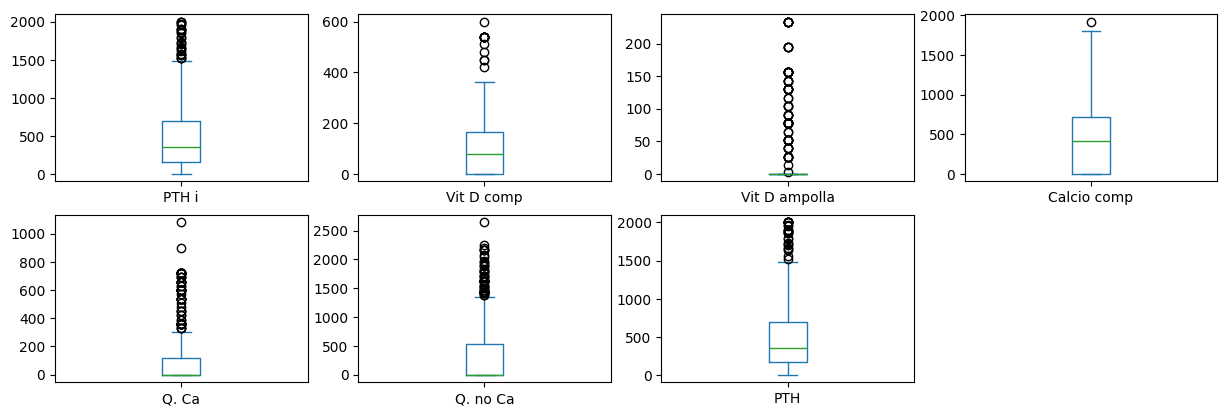

In [ ]:
# prompt: Plot boxplots for every column of the dataframe. Make them in only one line, so I can compare them.

df_reg_red.plot(
    kind="box",
    subplots=True,
    layout=(4, 4),
    figsize=(15, 10),
    sharex=False,
    sharey=False,
)
plt.show()

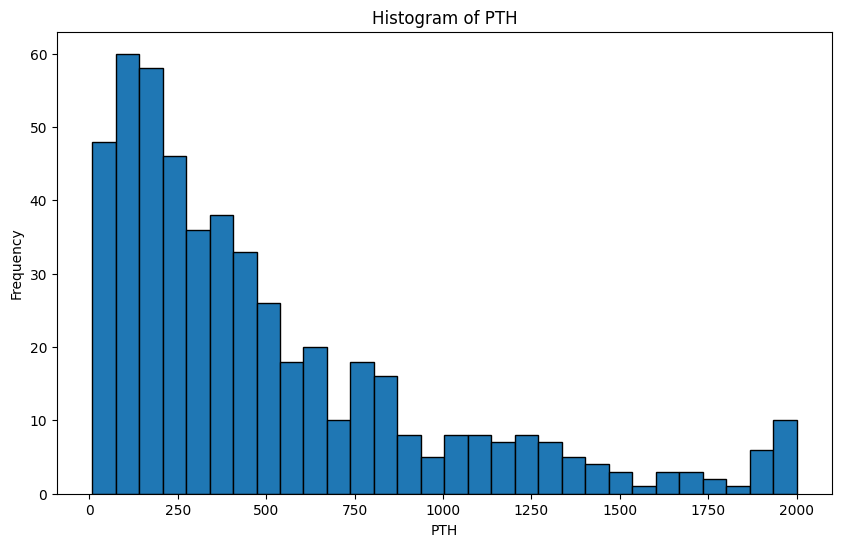

In [ ]:
# prompt: Show histogram of Y variable

plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, edgecolor="black")  # Adjust the number of bins as needed
plt.xlabel("PTH")
plt.ylabel("Frequency")
plt.title("Histogram of PTH")
plt.show()

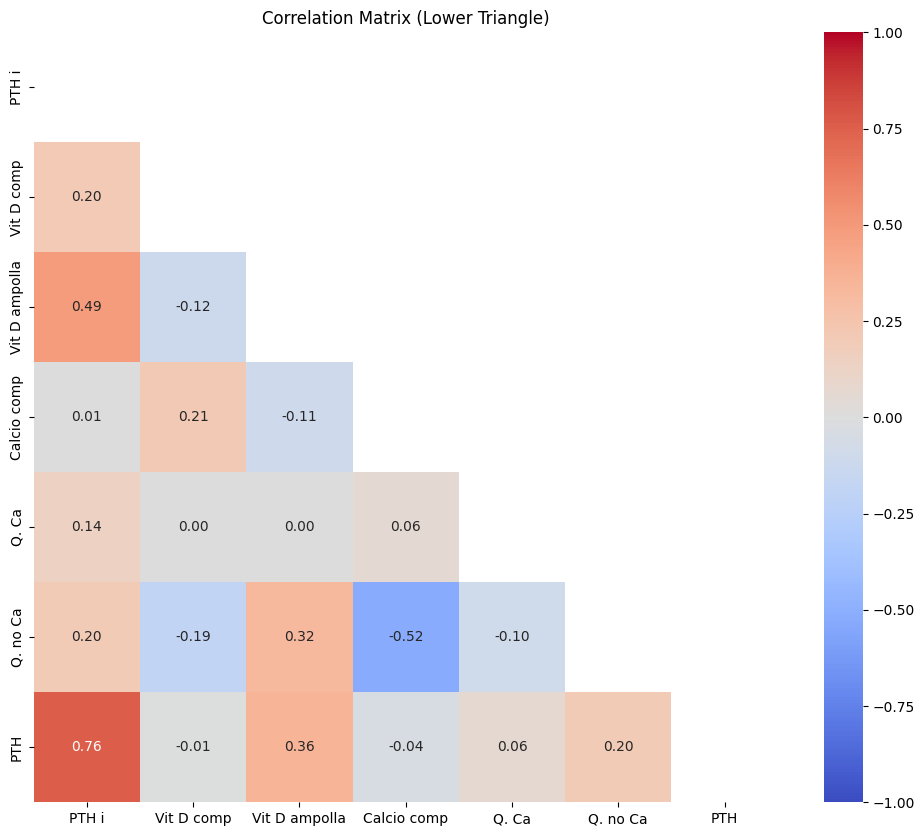

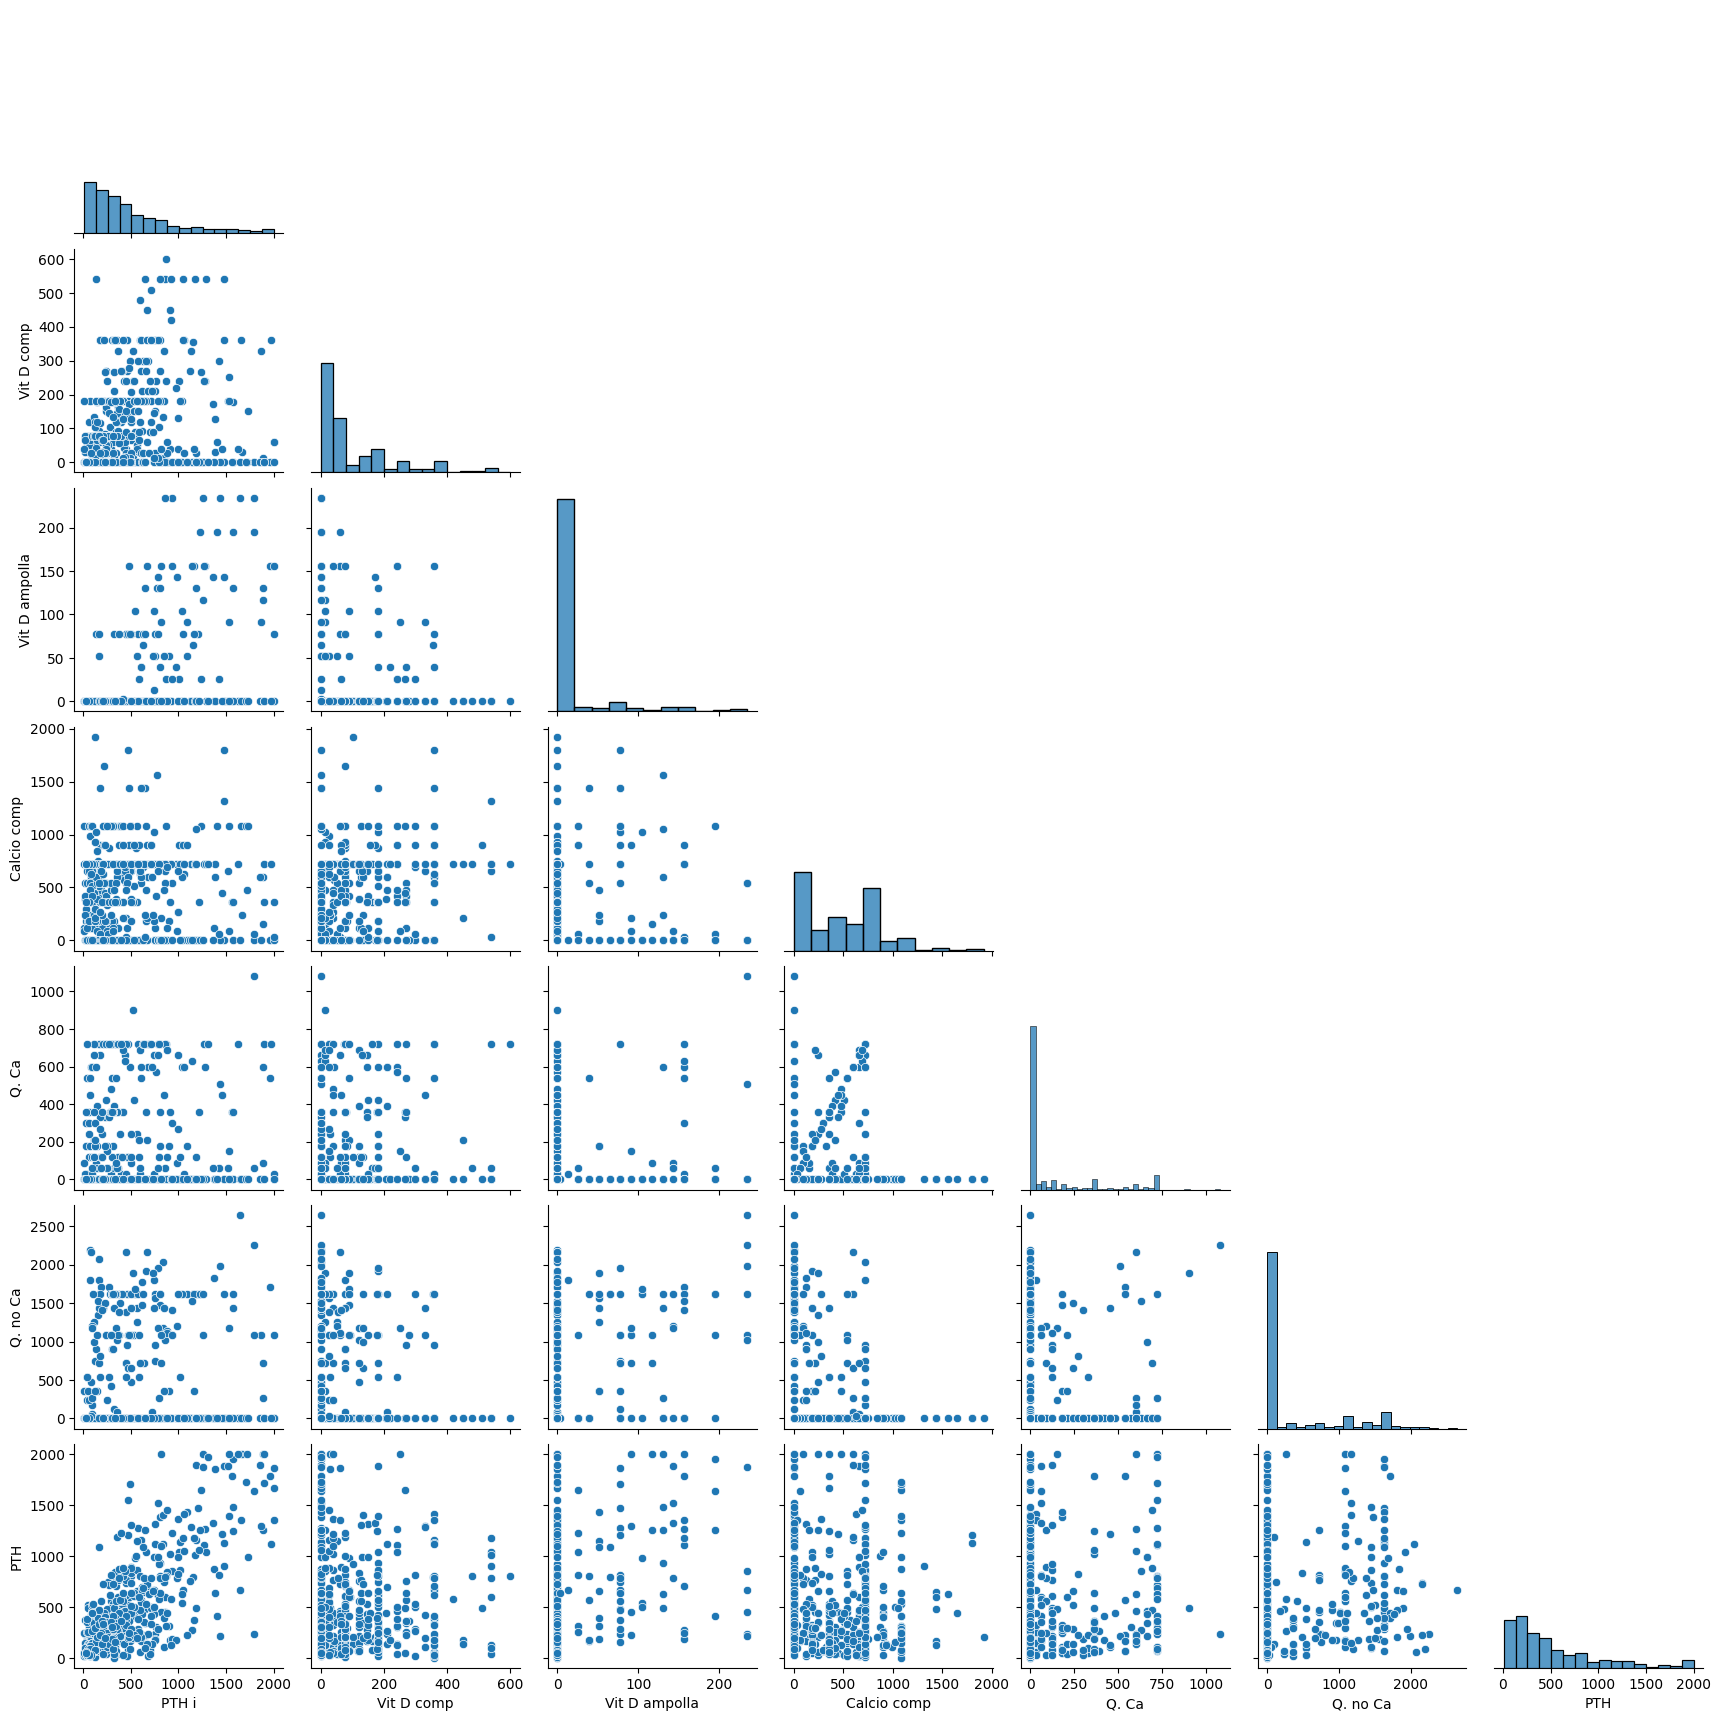

In [ ]:
# prompt: Plot that shows the relationship between all variables. Only show lower triangle. Also show correlation matrix.

# Calculate the correlation matrix
correlation_matrix = df_reg_red.corr()

# Plotting the lower triangle of the correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Matrix (Lower Triangle)")
plt.show()

# Plotting the relationships between all variables (lower triangle)
sns.pairplot(df_reg_red, corner=True)  # corner=True shows only the lower triangle
plt.show()

Se puede apreciar que hay varias variables correlacionadas con una moderada fuerza:
1. PTH inicial con Vit. D Ampolla
2. PTH inicial con final (esta es clara)
3. Calcio comp. con Q no Ca

Esta redundancia de información puede afectar, en términos generales, a aumentar a la complejidad del modelo sin necesariamente tener que mejorar su performance. El problema sobre todo surge a la hora de interpretar los datos: si dos o más variables están fuertemente relacionadas pueden confundirse sus efectos sobre la variable a predecir.
A pesar de esto, el modelo que queremos entrenar con XGBoost es robusto a este fenónmeno y no se ve demasiado afectado por el mismo.
Esto se debe a que, al usar árboles de decisión, el mismo modelo opta por alguna de las variables para realizar las divisiones.

Vamos a analizar ahora si al splitear los datos en Training, Validation y Testing quedaron homogéneamente distribuídos. Esto es importante (sobre todo para clasificación) el modelo puede no generalizar bien. Por ejemplo, si el conjunto de validación tiene un sesgo hacia ciertos valores (como observaciones en las colas), las métricas de validación podrían no ser representativas.

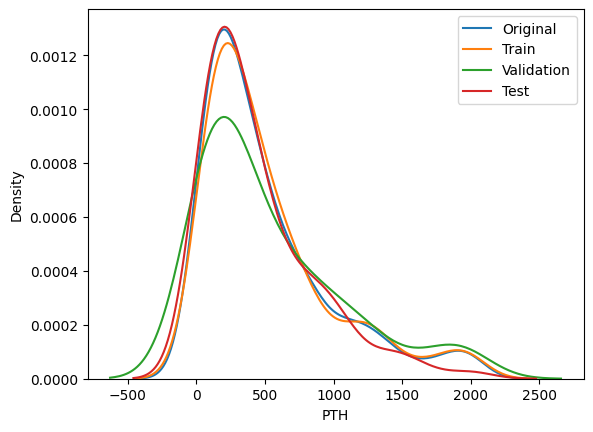

In [ ]:
# Comparar la distribución de 'y' en el conjunto original y el de entrenamiento
sns.kdeplot(y, label="Original")
sns.kdeplot(y_train, label="Train")
sns.kdeplot(y_val, label="Validation")
sns.kdeplot(y_test, label="Test")
plt.legend()
plt.show()

La diferencia que hay entre el original y sobre todo el set de Validación muestra que hace falta separar los datos más a conciencia. Para esto, se puede usar **stratify**

In [ ]:
# Reducir el número de bins para la variable continua 'y'
# Aquí usamos qcut para crear 5 bins con cantidades similares de datos
bins = pd.qcut(y, q=5, duplicates="drop")  # Ajusta el número de bins según lo necesario

# Dividir en entrenamiento, validación y prueba usando estratificación por bins
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=bins, random_state=42
)

# Recalcular los bins para el conjunto temporal
bins_temp = pd.qcut(y_temp, q=5, duplicates="drop")

# Dividir en validación y prueba usando estratificación por bins temporales
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=bins_temp, random_state=42
)

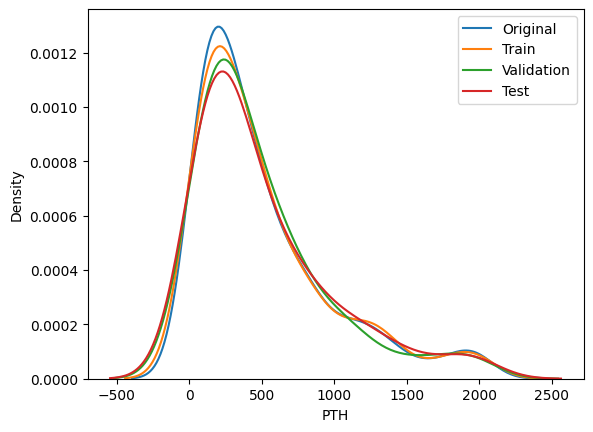

In [ ]:
# Comparar la distribución de 'y' en el conjunto original y el de entrenamiento
sns.kdeplot(y, label="Original")
sns.kdeplot(y_train, label="Train")
sns.kdeplot(y_val, label="Validation")
sns.kdeplot(y_test, label="Test")
plt.legend()
plt.show()

Se nota que mejoró mucho!

Arrancamos a entrenar el modelo:

In [ ]:
# Define XGBRegressor model parameters
params = {
    #'objective': 'reg:squarederror',
    "objective": "reg:absoluteerror",  # Da mejor R2 usando absolute que squared
    "max_depth": 15,
    "learning_rate": 0.005,
    "n_estimators": 100000,
    "subsample": 0.5,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "early_stopping_rounds": 350,
    "eval_metric": "mae",
    #'eval_metric': 'rmse',
    "max_leaves": 10,
}

# Instantiate XGBRegressor with the parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=350,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [ ]:
# Ahora vamos a predecir los valores de test
y_pred = model.predict(X_test)

R2 = r2_score(y_test, y_pred)
print(f"R2: {R2:.3f}")

R2: 0.595


No es muy bueno. Vamos a emplear ahora los datos extendidos.

( Para correr el código en esta instancia hay que subir y cargar los datos de **X** e **y** relativos a los datos extendidos

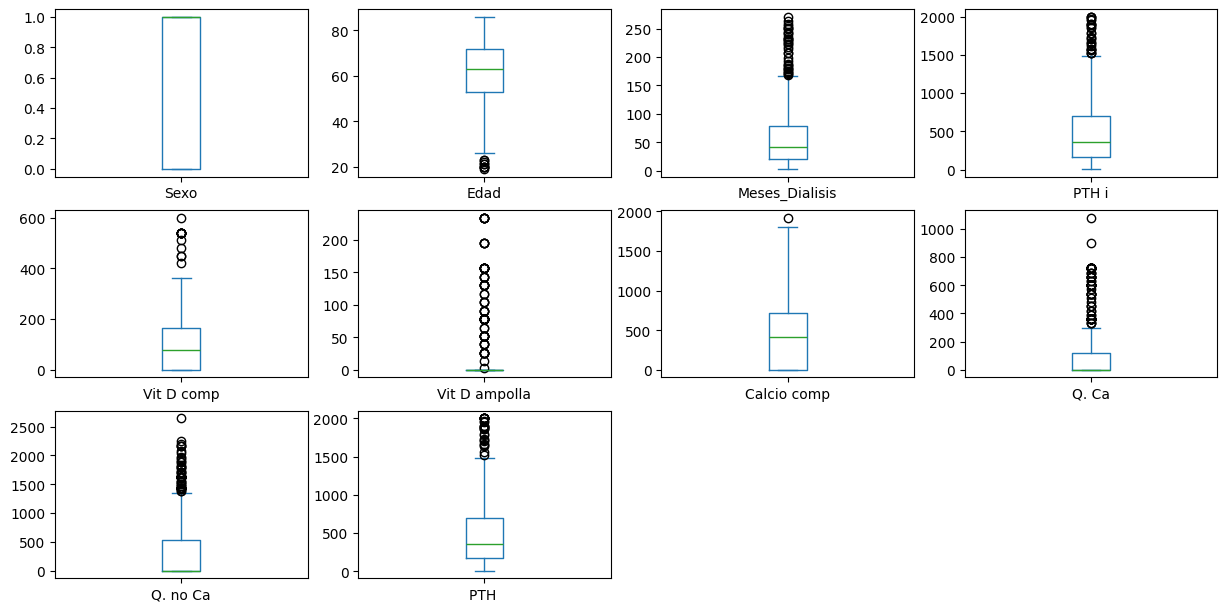

In [ ]:
df_reg_ext.plot(
    kind="box",
    subplots=True,
    layout=(4, 4),
    figsize=(15, 10),
    sharex=False,
    sharey=False,
)


plt.show()

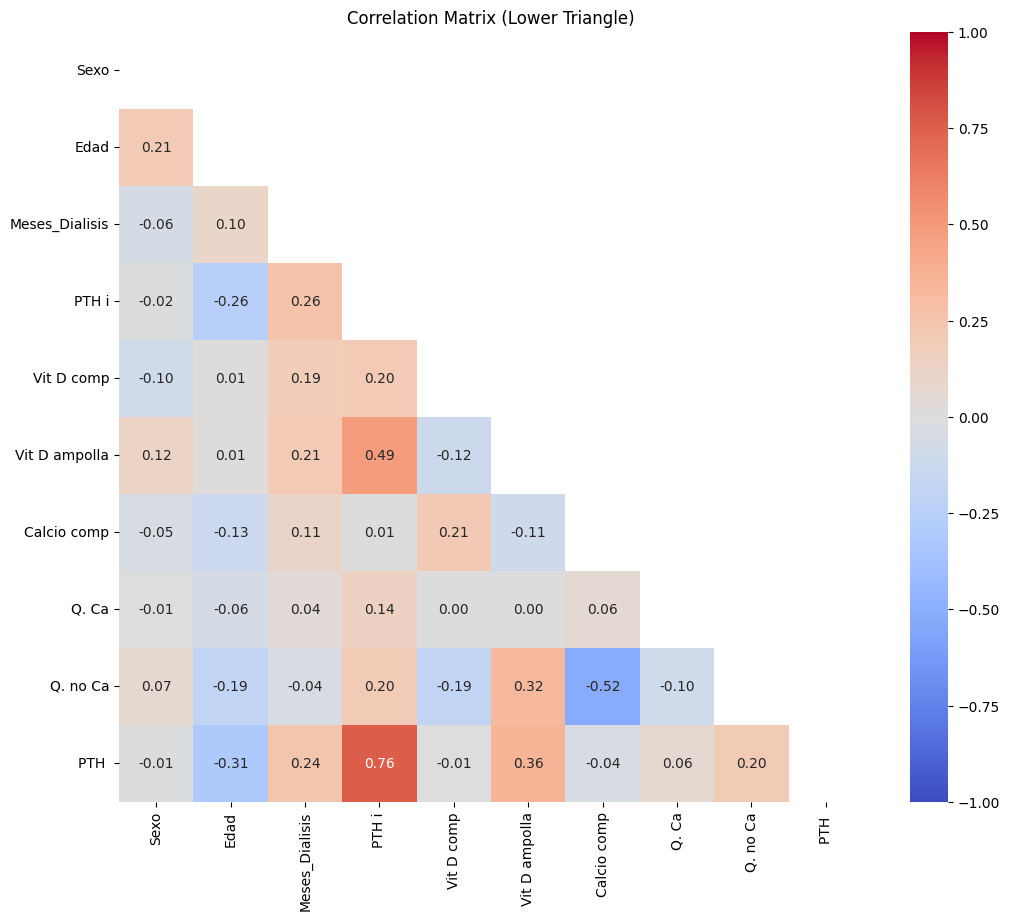

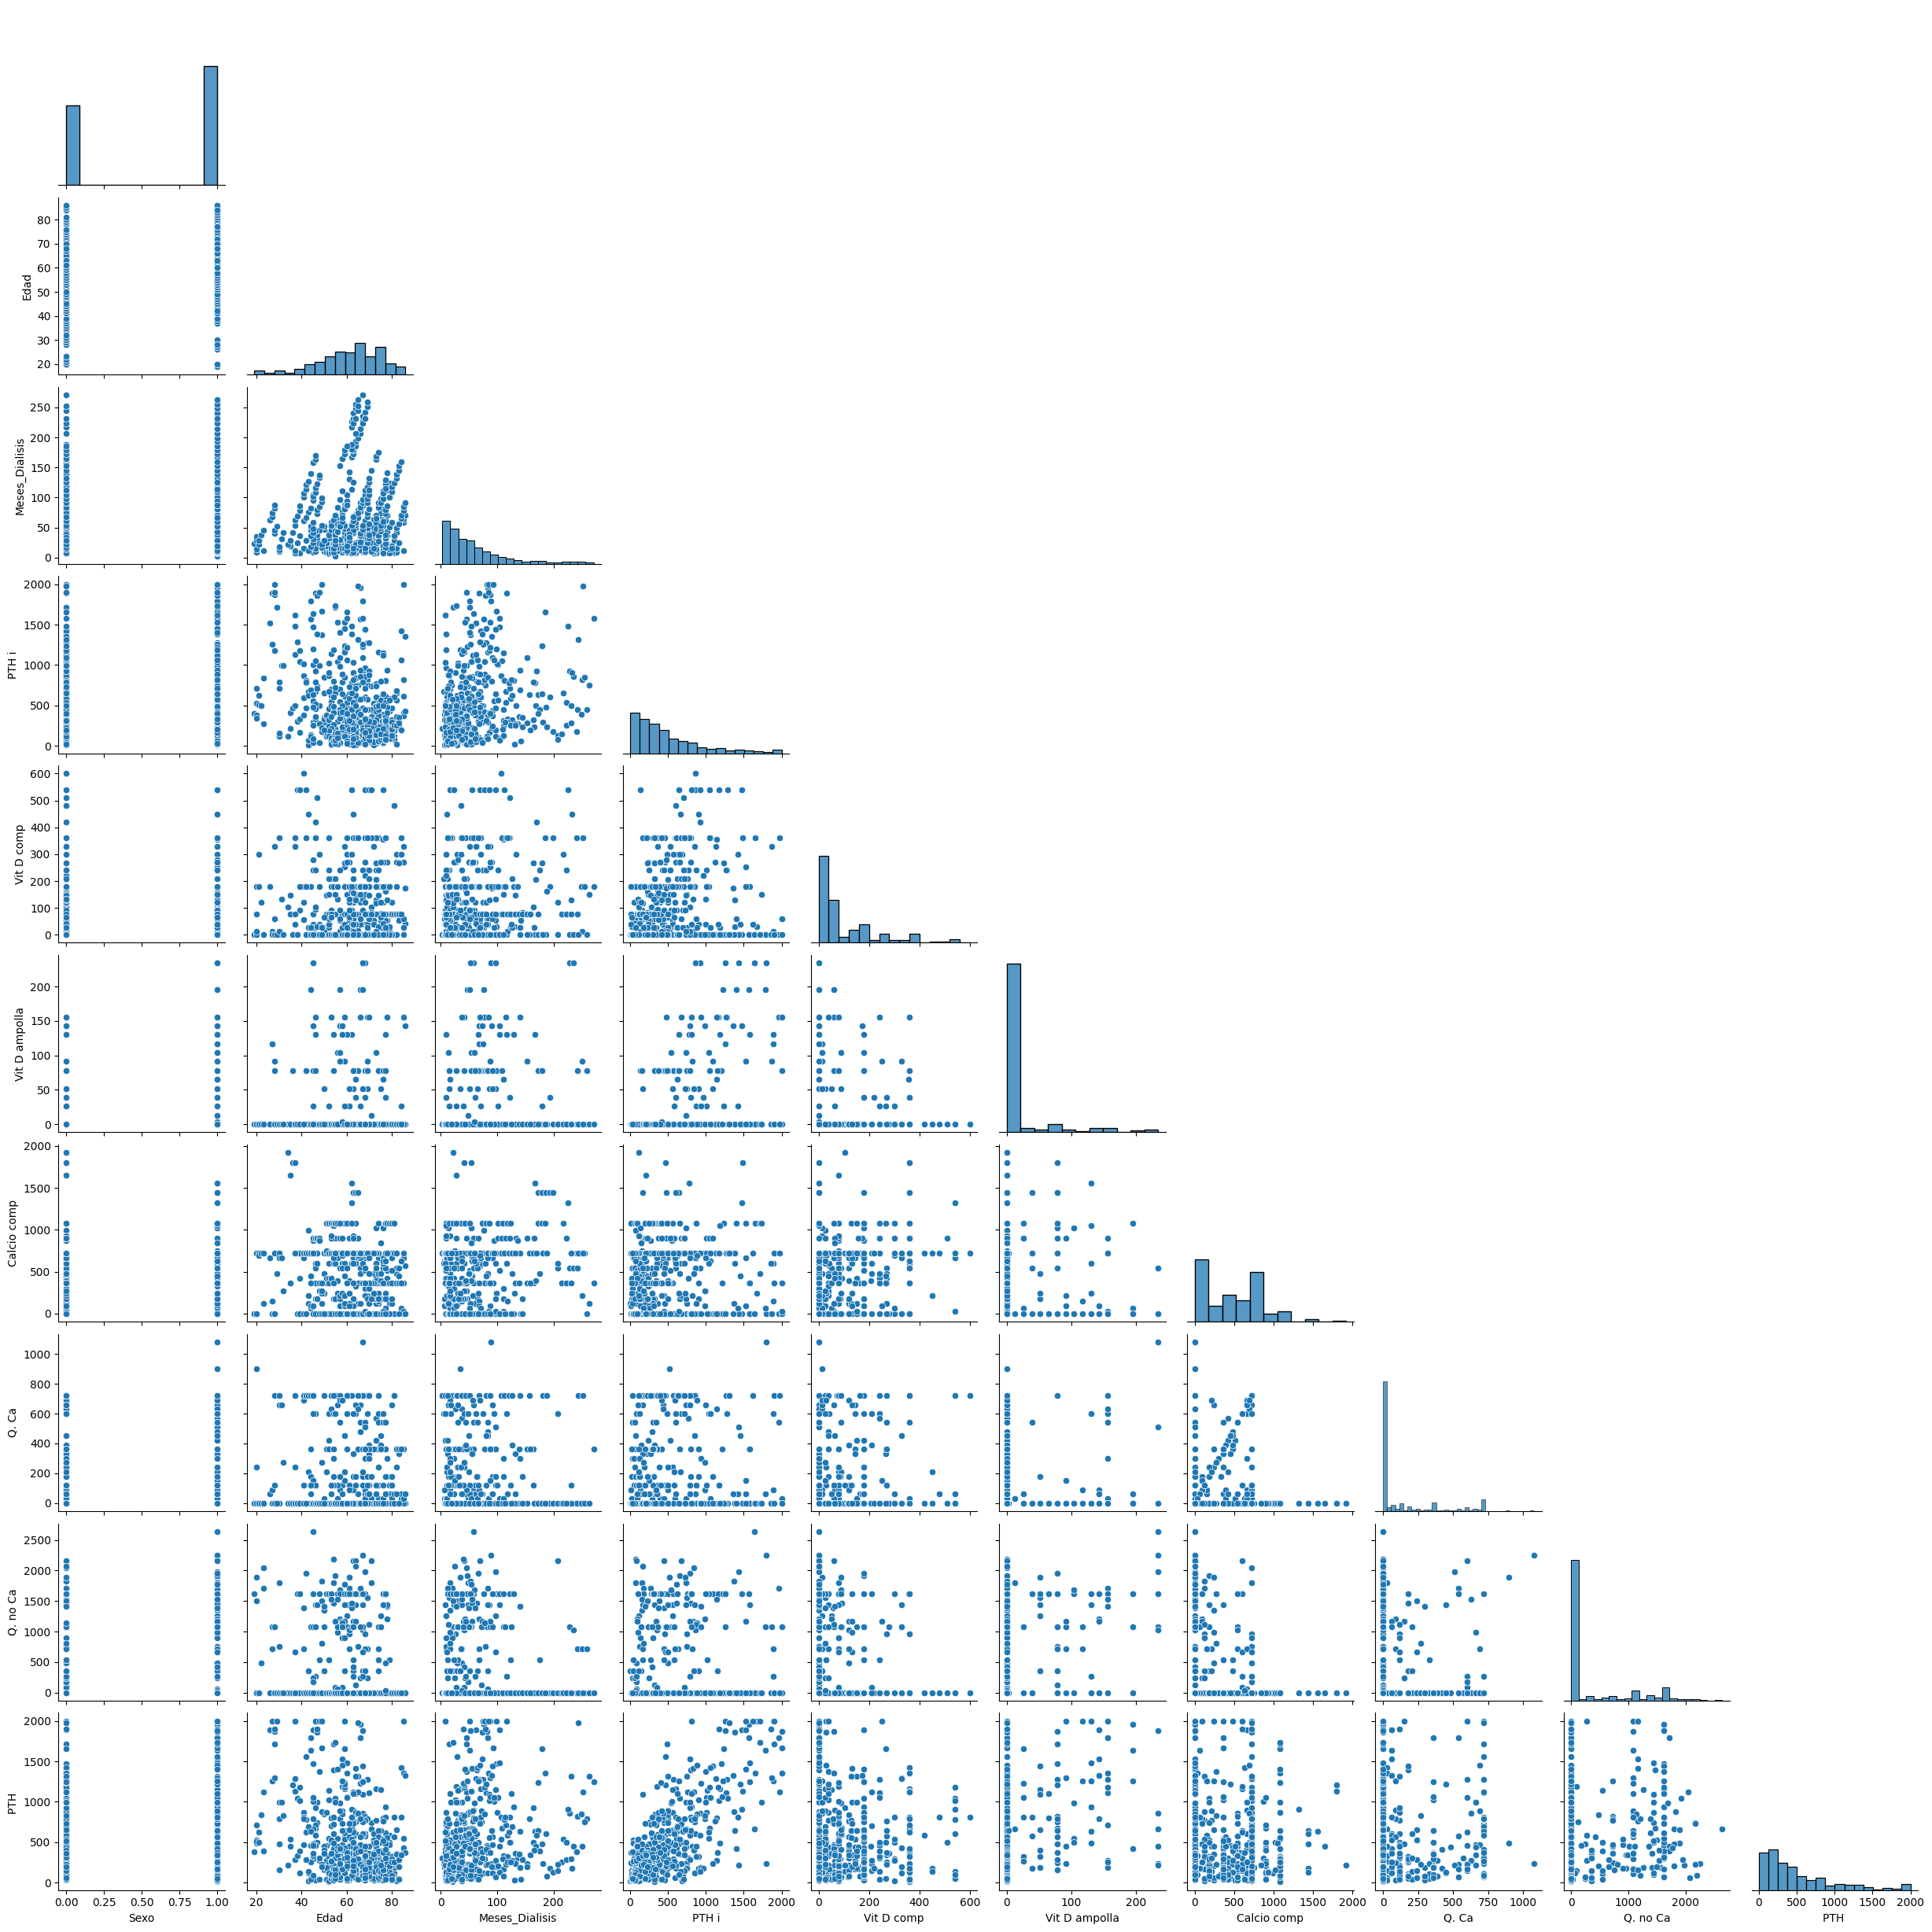

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_reg_ext.corr()

# Plotting the lower triangle of the correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Matrix (Lower Triangle)")
plt.show()

# Plotting the relationships between all variables (lower triangle)
sns.pairplot(df_reg_ext, corner=True)  # corner=True shows only the lower triangle
plt.show()

Y nuevamente vamos a calcular el modelo

**Parámetros utilizados para entrenar un modelo de regresión en XGBoost**

A continuación, se explican los parámetros utilizados para entrenar un modelo de regresión con la biblioteca XGBoost. Este conjunto de parámetros está diseñado para optimizar el rendimiento del modelo utilizando el error absoluto como métrica principal.

**Parámetros y su explicación**

- **`objective`**:  
  Define la función objetivo para la regresión. En este caso, se utiliza:
  - `'reg:absoluteerror'`: Minimiza el error absoluto (MAE), que es más robusto frente a outliers en comparación con el error cuadrático medio (MSE). Según pruebas realizadas, este objetivo ofrece un mejor coeficiente R² en este modelo.
  - Comentado: `'reg:squarederror'` (error cuadrático).

- **`max_depth`**:  
  Especifica la profundidad máxima de cada árbol. Un valor mayor como `15` permite que el modelo capture interacciones más complejas, pero puede aumentar el riesgo de sobreajuste.

- **`learning_rate`**:  
  Controla el tamaño de los pasos que da el modelo al optimizar. Un valor bajo como `0.005` asegura una convergencia más estable y precisa, aunque requiere más iteraciones.

- **`n_estimators`**:  
  Número máximo de árboles que se entrenarán. En este caso, se establece en `100,000`, pero el entrenamiento puede detenerse antes debido a la estrategia de `early_stopping_rounds`.

- **`subsample`**:  
  Fracción de muestras utilizadas para entrenar cada árbol. Un valor de `0.5` significa que el modelo usará el 50% de los datos en cada iteración, lo que ayuda a prevenir el sobreajuste.

- **`colsample_bytree`**:  
  Fracción de características seleccionadas de manera aleatoria para construir cada árbol. Con `0.8`, el modelo utiliza el 80% de las características en cada iteración, lo que también ayuda a reducir el riesgo de sobreajuste.

- **`random_state`**:  
  Semilla aleatoria para garantizar la reproducibilidad de los resultados. Se establece en `42` como valor estándar para experimentos reproducibles.

- **`early_stopping_rounds`**:  
  Número de iteraciones sin mejora en la métrica de evaluación antes de detener el entrenamiento. En este caso, si no hay mejora en `350` rondas consecutivas, el entrenamiento se detendrá.

- **`eval_metric`**:  
  Métrica utilizada para evaluar el desempeño del modelo durante el entrenamiento. En este caso:
  - `'mae'`: Error absoluto medio, que mide la desviación promedio entre las predicciones y los valores reales.
  - Comentado: `'rmse'` (raíz del error cuadrático medio), que da más peso a los errores grandes.

- **`max_leaves`**:  
  Especifica el número máximo de hojas en los árboles. Con `10`, se limita la complejidad de cada árbol, lo que puede ayudar a controlar el sobreajuste.

In [ ]:
params = {
    #'objective': 'reg:squarederror',
    "objective": "reg:absoluteerror",  # Da mejor R2 usando absolute que squared
    "max_depth": 15,
    "learning_rate": 0.005,
    "n_estimators": 100000,
    "subsample": 0.5,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "early_stopping_rounds": 350,
    "eval_metric": "mae",
    #'eval_metric': 'rmse',
    "max_leaves": 10,
}

# Instantiate XGBRegressor with the parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=350,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [ ]:
# Ahora vamos a predecir los valores de test
y_pred = model.predict(X_test)

R2 = r2_score(y_test, y_pred)
print(f"R2: {R2:.3f}")

R2: 0.645


El R2 mejoró! Representa un aumento del 8.5% respecto del dataset anterior.

Vamos a recurrir a un método más robusto y automatizado para buscar los parámetros óptimos: **GridSearch**

In [ ]:
# Parámetros a explorar
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.4, 0.6, 0.8],
}

# Configura el modelo base
xgb_model = xgb.XGBRegressor(random_state=42)

# Configura GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="r2",  # Métrica a optimizar
    cv=3,  # Número de validaciones cruzadas
    verbose=2,
    n_jobs=-1,  # Usa todos los núcleos disponibles
)

# Realiza la búsqueda
grid_search.fit(X_train, y_train)

# Imprime los mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor R2 obtenido:", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mejores parámetros: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}
Mejor R2 obtenido: 0.5470074513869142


Empleamos los valores hallados para recalcular el modelo.

In [ ]:
params = {
    "objective": "reg:absoluteerror",
    "max_depth": 5,
    "learning_rate": 0.1,
    "n_estimators": 100,
    "subsample": 0.45,
    "colsample_bytree": 0.6,
    "random_state": 42,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "max_leaves": 16,
}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

y_pred = model.predict(X_test)
R2 = r2_score(y_test, y_pred)

print(f"R2: {R2:.3f}")

R2: 0.698


Volvemos a ver un incremento del 8% aproximadamente respecto del anterior.
Vamos a visualizar los datos predichos versus los datos reales para ver qué tan bien ajustó el modelo.

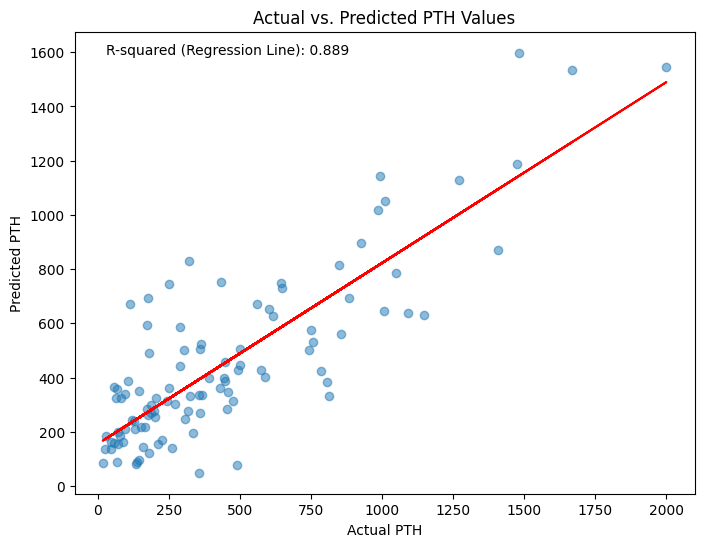

In [ ]:
# prompt: Graficar un scatter con una recta de regresión de los Y predichos vs los Y reales. Mostrar el ajuste de R2 de esa recta.

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual PTH")
plt.ylabel("Predicted PTH")
plt.title("Actual vs. Predicted PTH Values")

# Fit a linear regression line to the data
lr = LinearRegression()
lr.fit(y_test.values.reshape(-1, 1), y_pred)  # Reshape y_test for single feature input
y_pred_line = lr.predict(y_test.values.reshape(-1, 1))
plt.plot(y_test, y_pred_line, color="red")

# Calculate R-squared for the linear regression line
r2_line = r2_score(y_test, y_pred_line)
plt.text(
    0.05,
    0.95,
    f"R-squared (Regression Line): {r2_line:.3f}",
    transform=plt.gca().transAxes,
)


plt.show()

In [ ]:
# prompt: Calcular la correlación entre Y predicho y real

from scipy.stats import pearsonr

correlation, p_value = pearsonr(y_test, y_pred)
print(f"Correlación de Pearson entre Y predicho y real: {correlation:.3f}")
print(f"Valor p: {p_value:.2E}")

Correlación de Pearson entre Y predicho y real: 0.837
Valor p: 1.91E-28


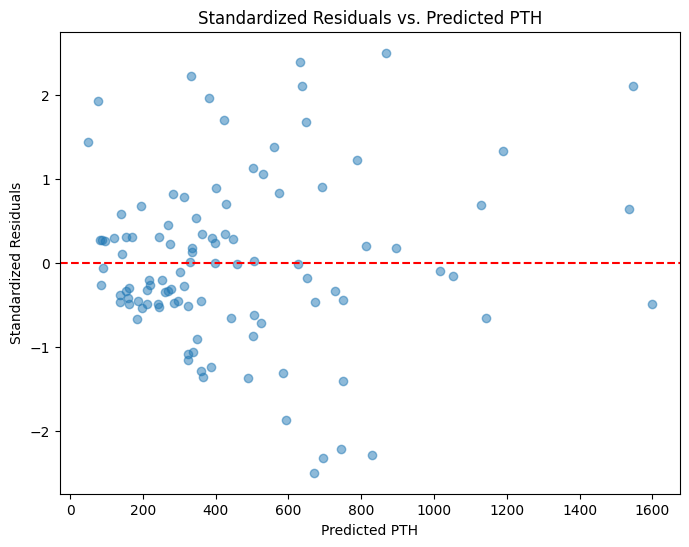

In [ ]:
# prompt: Graficar los residuos estandarizados de y predicho vs y real

# Calculate standardized residuals
residuals = y_test - y_pred
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, std_residuals, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")  # Add a horizontal line at y=0
plt.xlabel("Predicted PTH")
plt.ylabel("Standardized Residuals")
plt.title("Standardized Residuals vs. Predicted PTH")
plt.show()

A pesar de haber una fuerte correlación entre la Y predicha y la real, y mostrar una tendencia lineal con un ajuste de R2 relativamente bueno, consideramos que este valor no es aceptable para el uso médico que se le quiere aplicar. La distancia entre los valores esperados y los calculados es muy amplia, lo cual se puede apreciar en el gráfico de residuos estandarizados.

Por lo tanto, vamos a cambiar el enfoque hacia un **modelo de clasificación**.

# Segunda parte - Modelo de clasificación

Para poder trabajar este dataset en formato de aprendizaje supervisado de clasificación, debemos hacer algunas modificaciones a los datos.

Transformamos los datos para que el valor obtenido de PTH esté:
1. Menor a 30 -- Categoría 0
2. Entre 30 y 585 -- Categoría 1
3. Mayor a 585 -- Categoría 3

(Aca hay que volver para arriba para descomentar y splitear de vuelta el X y Y multiclase)

In [ ]:
df_cat_multiclass.head()

,Sexo,Edad,Meses_Dialisis,PTH i,Vit D comp,Vit D ampolla,Calcio comp,Q. Ca,Q. no Ca,PTH
Paciente,,,,,,,,,,
1,0,63.0,58.0,502.0,65,0,660,90,0,2
2,0,63.0,65.0,901.0,0,52,180,180,360,1
3,0,64.0,72.0,320.0,0,78,0,0,120,2
4,0,65.0,79.0,750.0,0,78,0,0,750,1
5,1,68.0,12.0,167.0,0,0,0,720,1620,1


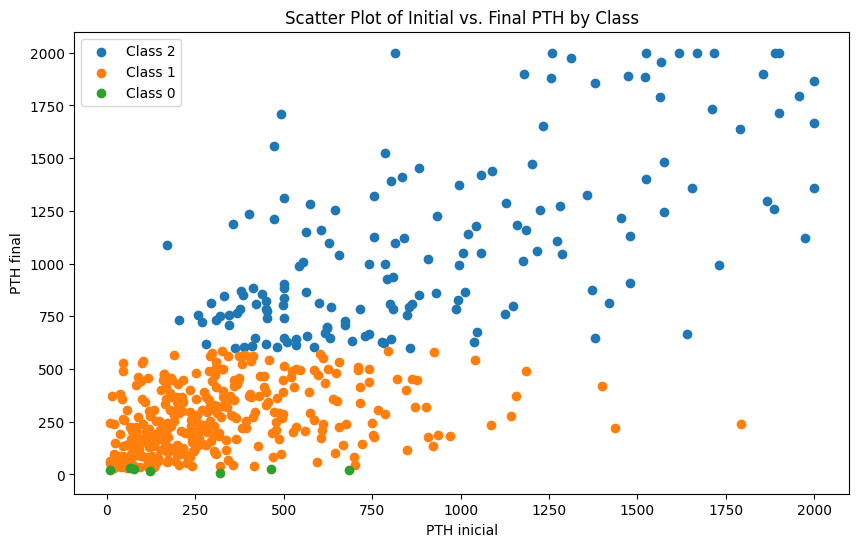

In [ ]:
plt.figure(figsize=(10, 6))
for class_label in df_cat_multiclass["PTH"].unique():
    subset = df_reg_ext[df_cat_multiclass["PTH"] == class_label]
    plt.scatter(subset["PTH i"], subset["PTH "], label=f"Class {class_label}")

plt.xlabel("PTH inicial")
plt.ylabel("PTH final")
plt.title("Scatter Plot of Initial vs. Final PTH by Class")
plt.legend()
plt.show()

Se puede apreciar claramente que las clases no están balanceadas:

In [ ]:
# prompt: Count elements per class in the 'PTH' column of df_cat_multiclass. Also, add a column showing the total porcentage of each class overall. Show all this in a dataframe format. Order by class ascending. Round percentage in 2 decimals.

# Count elements per class and calculate percentage
class_counts = df_cat_multiclass["PTH"].value_counts().sort_index()
total_count = len(df_cat_multiclass)
percentages = (class_counts / total_count * 100).round(2)

# Create a DataFrame
class_summary = pd.DataFrame({"Count": class_counts, "Percentage": percentages})

# Display the DataFrame
class_summary

,Count,Percentage
PTH,,
0,7,1.36
1,352,68.22
2,157,30.43


Considerando este fuerte desbalance, y que la clase 0 no es la más relevante y habitual dentro del ámbito médico, vamos a fusionarla con la categoría 1, quedando así:
* Categoría 0 -- PTH menor o igual a 585
* categoría 1 -- PTH superior a 585

(Ahora volver a descomentar y hacer separacion binaria)

Procedemos a entrenar al modelo

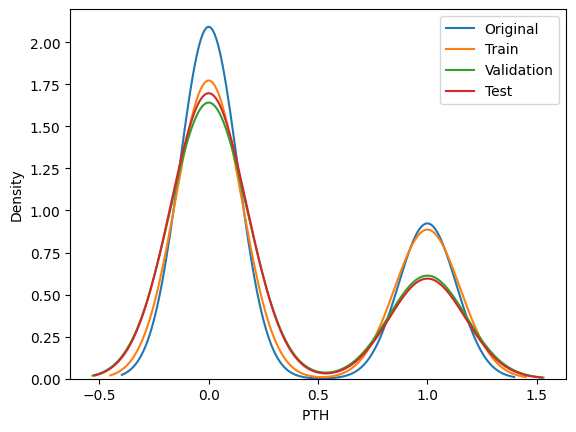

In [ ]:
# Spliteo de los datos
# X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)
# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=2024)


# Reducir el número de bins para la variable continua 'y'
# Aquí usamos qcut para crear 5 bins con cantidades similares de datos
bins = pd.qcut(y, q=5, duplicates="drop")  # Ajusta el número de bins según lo necesario

# Dividir en entrenamiento, validación y prueba usando estratificación por bins
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=bins, random_state=42
)

# Recalcular los bins para el conjunto temporal
bins_temp = pd.qcut(y_temp, q=5, duplicates="drop")

# Dividir en validación y prueba usando estratificación por bins temporales
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=bins_temp, random_state=42
)


# Comparar la distribución de 'y' en el conjunto original y el de entrenamiento
sns.kdeplot(y, label="Original")
sns.kdeplot(y_train, label="Train")
sns.kdeplot(y_val, label="Validation")
sns.kdeplot(y_test, label="Test")
plt.legend()
plt.show()

In [ ]:
# prompt: Count elements per class in the 'PTH' column of df_cat_multiclass. Also, add a column showing the total porcentage of each class overall. Show all this in a dataframe format. Order by class ascending. Round percentage in 2 decimals.

# Count elements per class and calculate percentage
class_counts = df_cat_binary["PTH "].value_counts().sort_index()
total_count = len(df_cat_binary)
percentages = (class_counts / total_count * 100).round(2)

# Create a DataFrame
class_summary = pd.DataFrame({"Count": class_counts, "Percentage": percentages})

# Display the DataFrame
class_summary

,Count,Percentage
PTH,,
0,358,69.38
1,158,30.62


(array([206.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 103.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

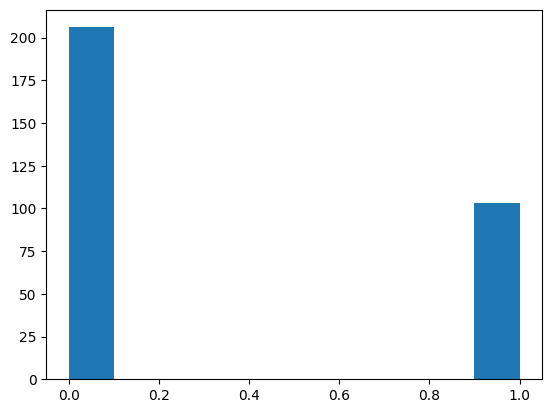

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(y_train)

(array([136.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 148.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

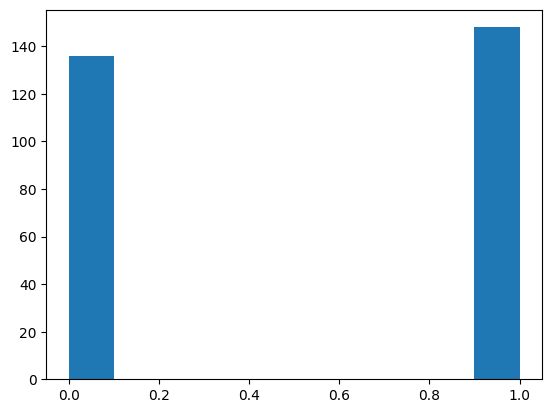

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN

# Create an imputer to replace NaN values with the mean of each column
imputer = SimpleImputer(strategy="mean")  # You can change the strategy if needed

# Fit the imputer to your training data and transform it
X_train_imputed = imputer.fit_transform(X_train)

# Now use the imputed data with SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train_imputed, y_train)

plt.hist(y_train_res)

In [ ]:
# Parámetros a explorar
param_grid = {
    # Generales
    "booster": ["gbtree"],  # Wrap 'gbtree' in a list
    "objective": ["binary:logistic"],  # Wrap 'binary:logistic' in a list
    "n_estimators": [100, 10000, 50000, 100000],
    "random_state": [42],  # Wrap 42 in a list
    # Parámetros del Booster
    "learning_rate": [0.01, 0.05, 0.001, 0.005],
    "max_depth": [5, 10, 15, 20],
    "subsample": [0.4, 0.5, 0.7, 0.8],
    "colsample_bytree": [0.4, 0.6, 0.8],
    # Parámetros de regularización
    "reg_lambda": [0.5],  # Wrap 0.5 in a list
    "reg_alpha": [0.5],  # Wrap 0.5 in a list
    # Parámetros específicos
    "eval_metric": ["logloss"],  # Wrap 'logloss' in a list
    "max_leaves": [10],  # Wrap 10 in a list
    "early_stopping_rounds": [500],  # Wrap 500 in a list
}

# Configura el modelo base
xgb_model = xgb.XGBClassifier(random_state=42)

# Configura GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="recall",  # Métrica a optimizar
    cv=3,  # Número de validaciones cruzadas
    verbose=2,
    n_jobs=-1,  # Usa todos los núcleos disponibles
)

# Realiza la búsqueda
grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Imprime los mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor recall obtenido:", grid_search.best_score_)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
[0]	validation_0-logloss:0.59234
[1]	validation_0-logloss:0.58846
[2]	validation_0-logloss:0.58641
[3]	validation_0-logloss:0.58365
[4]	validation_0-logloss:0.58257
[5]	validation_0-logloss:0.57954
[6]	validation_0-logloss:0.57627
[7]	validation_0-logloss:0.57245
[8]	validation_0-logloss:0.56921
[9]	validation_0-logloss:0.56646
[10]	validation_0-logloss:0.56389
[11]	validation_0-logloss:0.56099
[12]	validation_0-logloss:0.55842
[13]	validation_0-logloss:0.55524
[14]	validation_0-logloss:0.55459
[15]	validation_0-logloss:0.55347
[16]	validation_0-logloss:0.55243
[17]	validation_0-logloss:0.55034
[18]	validation_0-logloss:0.54747
[19]	validation_0-logloss:0.54493
[20]	validation_0-logloss:0.54262
[21]	validation_0-logloss:0.54033
[22]	validation_0-logloss:0.53984
[23]	validation_0-logloss:0.53709
[24]	validation_0-logloss:0.53488
[25]	validation_0-logloss:0.53397
[26]	validation_0-logloss:0.53212
[27]	validation_0-logloss:0.

In [ ]:
# Parámetros del modelo IMPLENTADO CON LOS PARAMETROS OBTENIDOS DEL GRID SEARCH
params = {
    # Generales
    "booster": "gbtree",
    "objective": "binary:logistic",
    #'n_estimators': 100000,
    "n_estimators": 10000,
    "random_state": 42,
    # Parámetros del Booster
    "learning_rate": 0.01,
    "max_depth": 5,
    "subsample": 0.4,
    "colsample_bytree": 0.8,
    # Parámetros de regularización
    "reg_lambda": 0.5,
    "reg_alpha": 0.5,
    # Parámetros específicos
    "eval_metric": "logloss",  # Métrica para evaluar
    "max_leaves": 10,
    "early_stopping_rounds": 500,  # Parada anticipada
}

# Instanciar el modelo
model = xgb.XGBClassifier(**params)

# Entrenamiento del modelo con conjunto de validación
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],  # Conjunto de validación
    verbose=True,  # Mostrar progreso durante el entrenamiento
)

[0]	validation_0-logloss:0.59460
[1]	validation_0-logloss:0.59077
[2]	validation_0-logloss:0.58763
[3]	validation_0-logloss:0.58457
[4]	validation_0-logloss:0.58191
[5]	validation_0-logloss:0.57875
[6]	validation_0-logloss:0.57499
[7]	validation_0-logloss:0.57172
[8]	validation_0-logloss:0.56996
[9]	validation_0-logloss:0.56740
[10]	validation_0-logloss:0.56501
[11]	validation_0-logloss:0.56218
[12]	validation_0-logloss:0.55932
[13]	validation_0-logloss:0.55786
[14]	validation_0-logloss:0.55713
[15]	validation_0-logloss:0.55411
[16]	validation_0-logloss:0.55099
[17]	validation_0-logloss:0.54855
[18]	validation_0-logloss:0.54585
[19]	validation_0-logloss:0.54374
[20]	validation_0-logloss:0.54179
[21]	validation_0-logloss:0.53947
[22]	validation_0-logloss:0.53758
[23]	validation_0-logloss:0.53519
[24]	validation_0-logloss:0.53313
[25]	validation_0-logloss:0.53134
[26]	validation_0-logloss:0.52930
[27]	validation_0-logloss:0.52812
[28]	validation_0-logloss:0.52544
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=500,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=10, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=None, num_parallel_tree=None,
              random_state=42, ...)

--------------------------------
-----METRICAS POR CATEGORIA-----
Precisión para la clase 0: 0.92
Recall  para  la  clase 0: 0.91
--------------------------------
Precisión para la clase 1: 0.75
Recall  para  la  clase 1: 0.78
--------------------------------
--------------------------------
------METRICAS GENERALES--------
Precision: 0.75
Recall: 0.78
Accuracy: 0.88
--------------------------------


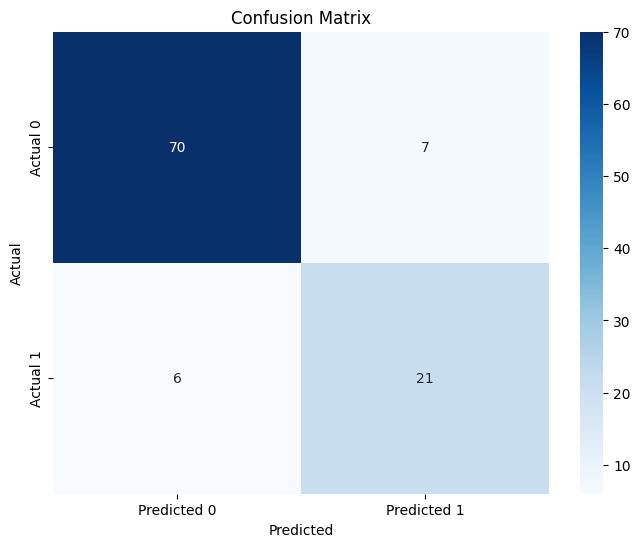

In [ ]:
# Import necessary libraries
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
)

# Predict on the test set
y_pred = model.predict(X_test)

# Calcular precisión y recall para la clase 0
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)

# Calcular precisión y recall para la clase 1
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

# Imprimir los resultados
print("--------------------------------")
print("-----METRICAS POR CATEGORIA-----")
print(f"Precisión para la clase 0: {precision_0:.2f}")
print(f"Recall  para  la  clase 0: {recall_0:.2f}")
print("--------------------------------")
print(f"Precisión para la clase 1: {precision_1:.2f}")
print(f"Recall  para  la  clase 1: {recall_1:.2f}")
print("--------------------------------")
print("--------------------------------")
print("------METRICAS GENERALES--------")
# Evaluate the model
precision_score = precision_score(y_test, y_pred)
print(f"Precision: {precision_score:.2f}")
recall_score = recall_score(y_test, y_pred)
print(f"Recall: {recall_score:.2f}")
accuracy_score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score:.2f}")
print("--------------------------------")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Recordemos que:
* **Accuracy**: es la proporción de predicciones correctas en todas las clases
* **Recall**: (Sensibilidad o Tasa de Verdaderos Positivos): Indica cuántos de los positivos reales fueron correctamente identificados


Podemos ver en la matriz de confusión que la clase 0 está muy bien predicha, con muy pocos valores mal etiquetados.

Sin embargo, la clase 1 presenta muchos valores que son falsamente catalogados como clase 0.

La métrica AUC-ROC evalúa la capacidad del modelo para diferenciar entre clases positivas y negativas a través de varios criterios de clasificación o umbrales de decisión al trazar la tasa de positivos verdaderos (TPR) versus la tasa de falsos positivos (FPR), como se ilustra a continuación.

AUC-ROC: 0.8942


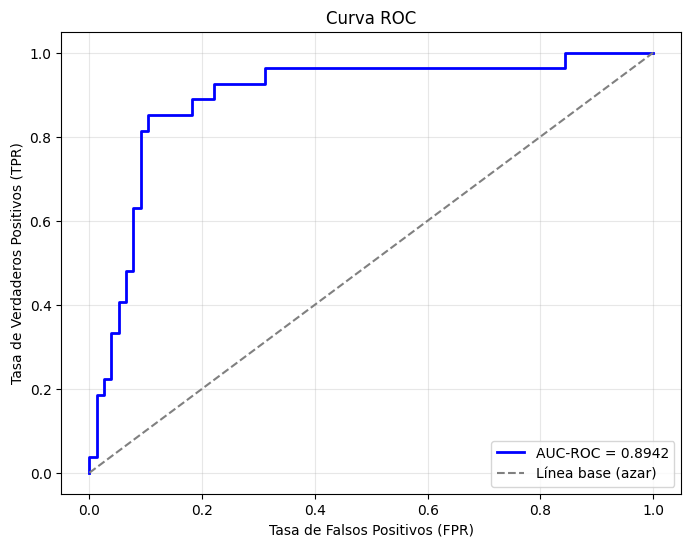

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Obtén las probabilidades predichas para la clase positiva
y_prob = model.predict_proba(X_test)[:, 1]

# Calcula la métrica AUC-ROC
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc:.4f}")

# Calcula los valores necesarios para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Gráfica de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.4f}", color="blue", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Línea base (azar)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

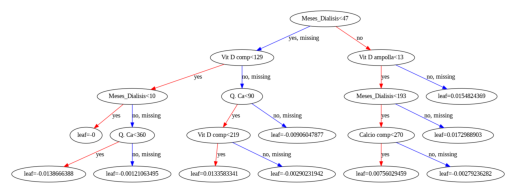

In [ ]:
import xgboost as xgb



xgb.plot_tree(model, num_trees=0)


plt.show()

<Figure size 1000x600 with 0 Axes>

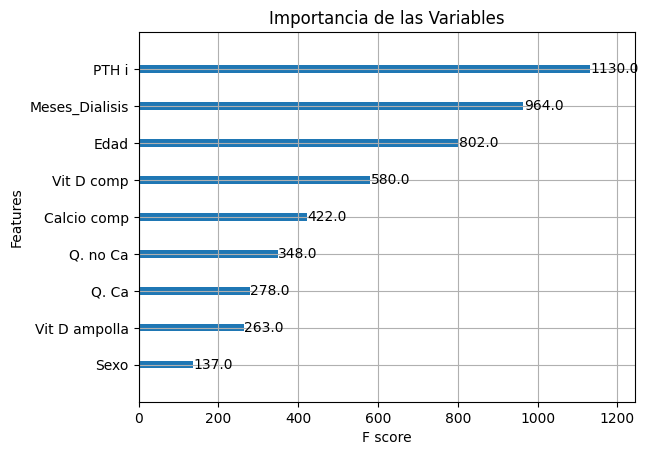

In [ ]:
# Gráfico de importancia de las variables
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type="weight")  # También puedes usar 'gain' o 'cover'
plt.title("Importancia de las Variables")
plt.show()

Es posible ver en el último gráfico la importancia de las variables en el proceso de entrenamiento del modelo. Se podría pensar viéndolo que variables como Sexo o "Vit D ampolla" no contribuyen demasiado al mismo, mientras que "PTH i" y "Meses_Dialisis" resultan clave para esto.